In [17]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import missingno as msno


from sklearn import manifold
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import (silhouette_score, adjusted_rand_score)

import seaborn as sns

# Segmentation de consommateurs (analyse du modèle collaboratif)

Ce notebook à pour objectif de représenter les caractéristiques sélectionées et de segmenter les consommateurs en plusieurs groupes représentatifs de leurs habitudes de consommation.
On considére ici le cas de l'algorithme collaboratif. On fournit une 20aine de vecteurs caractéristiques. Ces vecteurs représentent au mieux le comportement des consommateurs vis à vis des produits (items) qu'ils consomment. Cependant ils ne sont pas interprétés qualitativement.

Nous cherchons donc à segmenter les consommateurs dans l'espace engendré par ces vecteurs

Nous analyserons les meilleurs paramètres de segmentation d'une part, et d'autre part la pertinence du bouquet de caractéristiques. Nous choisirons un nombre de clusters approprié en étudiant la correspondance entre des des données test préalablement importées (voir notebook create_cf_model) et les modèles entrainés en utilisant des métriques telles que l'indice de rand normalisé. Nous représenterons ensuite graphiquement (en deux dimensions) les différents clusters via des algorithmes de représentations tels que TSNE ou ISOMAP. Pour finir, nous tenterons une interpréteron des clusters via une analyse manuelle de la nature des transactions effectuées par les utilisateurs de chaque cluster et via l'analyse d'une variable statistique basée sur la popularitée




# I) Segmentation 


In [38]:
def entrainement_model(mod_train,mod_test):    
    
    # rescaling features

    mod1_train = StandardScaler().fit_transform(mod_train)
    mod1_test = StandardScaler().fit_transform(mod_test)
    
    # étude du coeficient de silhouette pour différent nombre de clusters et sauvegarde des labels

    # nombre de cluster 
    clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]

    # coef silhouette 
    silhouette = []
    
    # indice de rand normalisé
    rand = []

    for k in range (len(clusters)):
        # appliquer le k-means (sur les données d'entrainement)
        kmeans = KMeans(n_clusters=int(clusters[k]),init='k-means++' ,random_state=0).fit(mod1_train)
        # enregistrer les labels 
        labels_train = kmeans.labels_
        # coeficient de silhouette correspondant
        silhouette.append(silhouette_score(mod1_test, kmeans.labels_, metric='euclidean'))
        # appliquer le k-nn sur les données test par rapport aux labels du k_means entrainé 
        neigh = KNeighborsClassifier(n_neighbors=3)
        neigh.fit(mod1_train, labels_train)
        
        labels_predict = neigh.predict(mod1_test)
        
        # enregistrer l'indice de rand normalisé entre le jeux d'entrainement et le jeux de test
        rand.append(adjusted_rand_score(labels_true=labels_train, labels_pred=labels_predict))

    # mettre les données dans un datasets 
    d = {'cluster': clusters, 'silhouette':silhouette, 'rand':rand}
    coef_df = pd.DataFrame(data=d)
    
    return (coef_df)

In [54]:
def entrainement_model_valid(mod_train,mod_test):    
    
    # rescaling features
    X = mod_train   
    mod1_train = StandardScaler().fit_transform(X)
    X = mod_test
    mod1_test = StandardScaler().fit_transform(X)
    
    
    
    # étude du coeficient de silhouette pour différent nombre de clusters et sauvegarde des labels

    # nombre de cluster 
    clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
    
    # nombre de voisins pour le knn 
    voisins = [2,3,4,5,6]

    # coef silhouette 
    silhouette = []
    
    # indice de rand normalisé
    rand = []
    
    # matrice de validation croisée : 
    valid = np.zeros((len(voisins),len(clusters)))

    for k in range (len(clusters)):
        for v in range (len(voisins)):
        
            # appliquer le k-means (sur les données d'entrainement)
            kmeans = KMeans(n_clusters=int(clusters[k]),init='k-means++' ,random_state=0).fit(mod1_train)
            # enregistrer les labels 
            labels_train = kmeans.labels_
           
            # appliquer le k-nn sur les données test par rapport aux labels du k_means entrainé 
            neigh = KNeighborsClassifier(n_neighbors=voisins[v])
            neigh.fit(mod1_train, labels_train)

            labels_predict = neigh.predict(mod1_test)
         
            # enregistre l'indice de rand dans la matrice de validation croisée
            valid[v,k] = adjusted_rand_score(labels_true=labels_train, labels_pred=labels_predict)

    # mettre les données dans un datasets 
    
    valid_df = pd.DataFrame(data=valid, index=np.array(voisins[:]), columns=np.array(clusters[:]))    
    
    return (valid_df)
    

In [52]:
def visualisation_reduite(df,n_clusters):
   
    
    df = StandardScaler().fit_transform(df)
    
    # ---------------------------- appliquer isomap (structure plutôt globale)----------------------------------

    iso = manifold.Isomap(n_neighbors=4,      
                           n_components=2)
    X_iso = iso.fit_transform(df)
    
    # appliquer le k-means sur les données réduites
    kmeans = KMeans(n_clusters=int(n_clusters),init='k-means++' ,random_state=0).fit(X_iso)
    
    # représenter les données 

    fig, ax = plt.subplots(figsize=(15, 15))  

    
    plt.scatter(X_iso[:, 0], X_iso[:, 1],c=kmeans.labels_)
    plt.title("Clustorisation et visualisation via l'algorithme isomap")
    #plt.axis([-2, 2, -2, 2])
    plt.savefig('user_map.png', dpi=400)
    plt.show()
    
    # ------------------------ appliquer l'algorithme tsne (structure plutôt locale) --------------------------------   
    
    tsne = manifold.TSNE(n_components=2, perplexity=50, n_iter=3000,init='pca' )
    X_tsne = tsne.fit_transform(df)
    
    # appliquer le k-means sur les données réduites
    kmeans = KMeans(n_clusters=int(n_clusters),init='k-means++' ,random_state=0).fit(X_tsne)
    # représenter les données 

    fig, ax = plt.subplots(figsize=(15, 15))  

    
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1],c=kmeans.labels_)
    plt.title("Clustorisation et visualisation via l'algorithme Tsne")
    #plt.axis([-2, 2, -2, 2])
    plt.savefig('user_map.png', dpi=400)
    plt.show()
    
    # ---------------------------------- appliquer une ACP linéaire en 2d ----------------------------------
    
    pca = decomposition.PCA(n_components=2) 
    pca.fit(df)
    print ('pourcentage de variance expliqué en deux dimensions')
    print (pca.explained_variance_ratio_.sum())
    X_projected = pca.transform(df)
    
    # appliquer le k-means sur les données réduites
    kmeans = KMeans(n_clusters=int(n_clusters),init='k-means++' ,random_state=0).fit(X_projected)
    # représenter les données 

    fig, ax = plt.subplots(figsize=(15, 15))  

   
    plt.scatter(X_projected[:, 0], X_projected[:, 1],c=kmeans.labels_)
    plt.title("Clustorisation et visualisation via l'algorithme une ACP")
    #plt.axis([-2, 2, -2, 2])
    plt.savefig('user_map.png', dpi=400)
    plt.show()
    
         
         
         
         



In [8]:
def visu_test(df,n_clusters):
    # ouvrir les annotations 
    
    title = pd.read_csv('fc_users_conv_red.csv')
    print (title.shape)
    df = StandardScaler().fit_transform(df)
    
    # appliquer le k-means en incluant toutes les dimensions
    kmeans = KMeans(n_clusters=int(n_clusters),init='k-means++' ,random_state=0).fit(df)
    
    
    
    # ---------------------------- appliquer isomap (structure plutôt globale)----------------------------------

    iso = manifold.Isomap(n_neighbors=4,      
                           n_components=2)
    X_iso = iso.fit_transform(df)
    
    list_up = []
    list_down = []
    for i in range (X_iso.shape[0]):
        print (title.iloc[i,2])
        if (X_iso[i,1] > -(1./10) * X_iso[i,0] + 1):
            list_up.append(title.iloc[i,2])
        if (X_iso[i,1] < -(1./10) * X_iso[i,0] + 1):
            list_down.append(title.iloc[i,2])
            
    # représenter les données 

    fig, ax = plt.subplots(figsize=(15, 15))  

    for i in range(title.shape[0]):    

        ax.annotate(title.iloc[i,2], (X_iso[i,0], X_iso[i,1]),size=6)
    plt.scatter(X_iso[:, 0], X_iso[:, 1],c=kmeans.labels_)
    plt.plot([0,10], [1,0],'-', markersize=6, c='red')
    plt.title("Clustorisation et visualisation via l'algorithme isomap")
    #plt.axis([-2, 2, -2, 2])
    plt.savefig('user_map_iso.png', dpi=400)
    plt.show()
            
    return (list_up, list_down)
        
    

In [27]:
folds = 5


for k in range (folds): 
    df_test = pd.read_csv('user_vecs_test{}.csv'.format(k))
    
    
    # ouvrir les données    
    df_train = pd.read_csv('user_vecs_train{}.csv'.format(k))

    # netoyer les données
    #df_train, df_test = netoyage(mod_train=df_train,mod_test=df_test)
    print (df_train.shape)
    print (df_test.shape)
    
    # créer le dictionnaire 
    if (k == 0):
        train = {'train{}'.format(k):df_train
                }
        test = {'test{}'.format(k):df_test     
               }
    # ajouter au dictionnaire
    if (k != 0):    
        
        train.update({'train{}'.format(k):df_train
                    }) 
        test.update({'test{}'.format(k):df_test
                    }) 





(200, 16)
(200, 16)
(200, 16)
(200, 16)
(200, 16)
(200, 16)
(200, 16)
(200, 16)
(200, 16)
(200, 16)


In [56]:
# implémenter une validation croisée pour trouver les meilleurs paramètres maximisant l'indice de rand normalisé 

for k in range (folds):
    
    # prendre en compte les caractéristiques qui nous interessent
    
       
    mod_train = np.matrix(train['train{}'.format(k)])
    print (mod_train.shape)
    
    
    mod_test = np.matrix(test['test{}'.format(k)])
    print (mod_test.shape) 
    
    
    
      
    # entrainer le modèle sur les k folds et moyenner les résultats 
    
    valid = entrainement_model_valid(mod_train=mod_train,mod_test=mod_test)
   
    if (k==0):        
        valid_tot = valid
    if (k>0):        
        valid_tot = valid_tot + valid       


valid_tot = valid_tot.divide(folds)


(200, 16)
(200, 16)
(200, 16)
(200, 16)
(200, 16)
(200, 16)
(200, 16)
(200, 16)
(200, 16)
(200, 16)


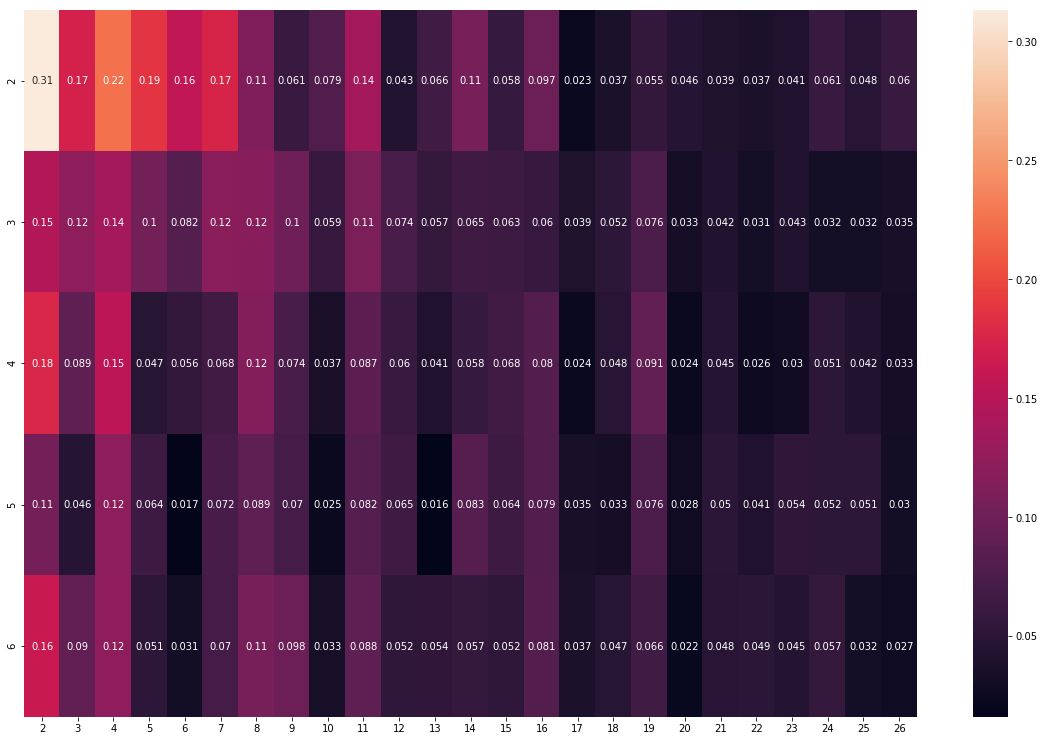

In [57]:
# visualiser la validation croisée sous la forme d'une heatmap

f, (ax1) = plt.subplots(1, 1, figsize=(20, 13), sharex=True)

sns.heatmap(data=valid_tot, annot=True)

In [39]:
for k in range (folds):
    
    # prendre en compte les caractéristiques qui nous interessent
    
    mod_train = np.matrix(train['train{}'.format(k)])
    print (mod_train.shape)
    
    mod_test = np.matrix(test['test{}'.format(k)])
    print (mod_test.shape)
    
       
    # réduire la dimension des données (via ACP) 
    
    pca = decomposition.PCA(n_components=2) 
    pca.fit(mod_train)
    print ('pourcentage de variance expliqué en deux dimensions pour le fold {}'.format(k))
    print (pca.explained_variance_ratio_.sum())
    X_projected = pca.transform(mod_train)
    
    # entrainer le modèle sur les k folds et moyenner les résultats 
    
    coef_df2 = entrainement_model(mod_train=mod_train,mod_test=mod_test)
    if (k==0):
        coef_tot2 = coef_df2
    if (k>0):
        coef_tot2 = coef_tot2 + coef_df2 

coef_tot2 = coef_tot2.divide(folds)

# afficher les résultats
print (coef_tot2)


(200, 16)
(200, 16)
pourcentage de variance expliqué en deux dimensions pour le fold 0
0.9997996043487203
(200, 16)
(200, 16)
pourcentage de variance expliqué en deux dimensions pour le fold 1
0.9998155858038483
(200, 16)
(200, 16)
pourcentage de variance expliqué en deux dimensions pour le fold 2
0.999842882705402
(200, 16)
(200, 16)
pourcentage de variance expliqué en deux dimensions pour le fold 3
0.9997948685945052
(200, 16)
(200, 16)
pourcentage de variance expliqué en deux dimensions pour le fold 4
0.999793122167641
    cluster  silhouette      rand
0         2    0.380800  0.146291
1         3    0.180395  0.122109
2         4    0.083726  0.137142
3         5    0.025476  0.103742
4         6   -0.053145  0.081720
5         7   -0.039885  0.118722
6         8   -0.120011  0.118093
7         9   -0.119835  0.099779
8        10   -0.194402  0.059437
9        11   -0.179537  0.109078
10       12   -0.213126  0.073771
11       13   -0.245173  0.057166
12       14   -0.258035  0.065

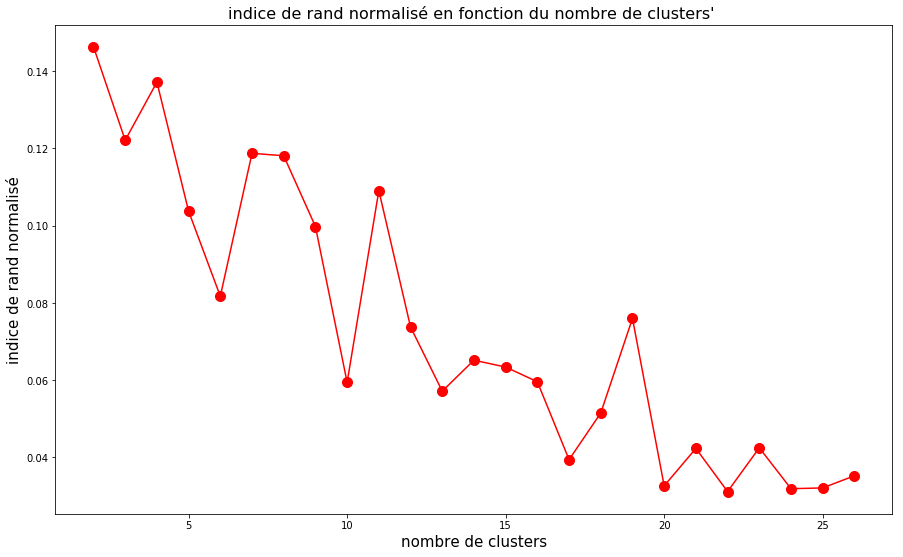

In [41]:
# visualisation des coeficients 
f, (ax1) = plt.subplots(1, 1, figsize=(15, 9), sharex=True)

#plt.plot(coef_tot.iloc[:,0], coef_tot.iloc[:,2],'-', markersize=6, c='blue')
#plt.plot(coef_tot.iloc[:,0], coef_tot.iloc[:,2],'ro', markersize=10, c='blue')
plt.plot(coef_tot2.iloc[:,0], coef_tot2.iloc[:,2],'-', markersize=6, c='red')
plt.plot(coef_tot2.iloc[:,0], coef_tot2.iloc[:,2],'ro', markersize=10, c='red')
#plt.plot(coef_tot.iloc[:,0], coef_tot.iloc[:,2],'ro', markersize=6, c='blue')
plt.title("indice de rand normalisé en fonction du nombre de clusters' ",fontsize=16)

ax1.set_xlabel("nombre de clusters",fontsize=15)
ax1.set_ylabel("indice de rand normalisé",fontsize=15)
plt.savefig('pict_reg_time1', dpi=400)
plt.show()

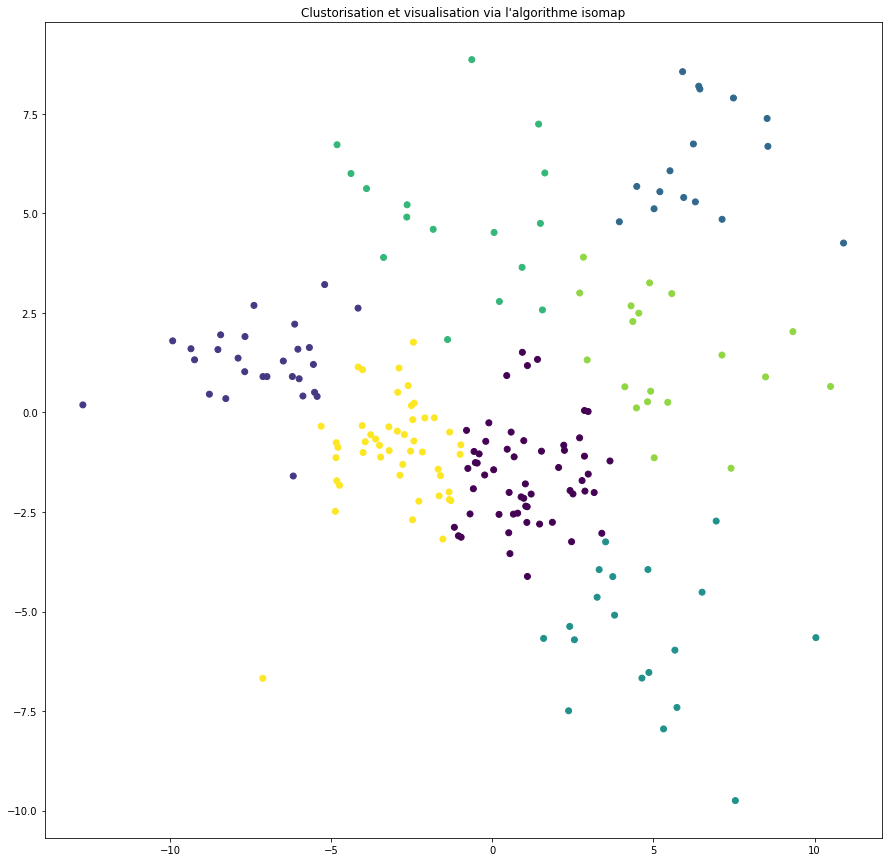

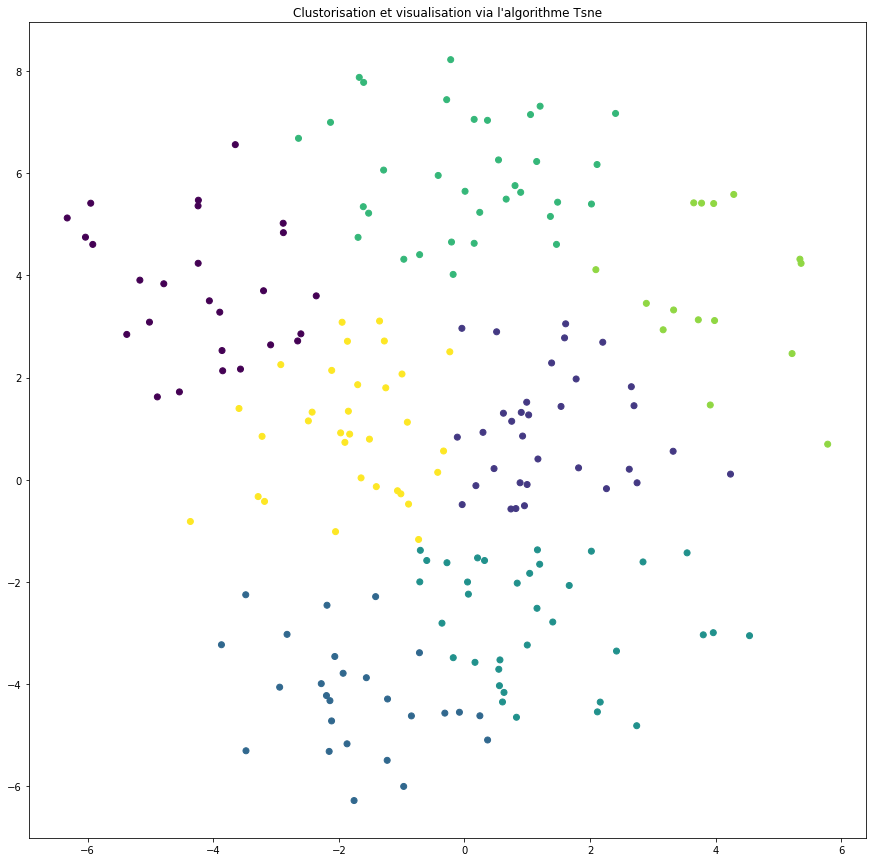

pourcentage de variance expliqué en deux dimensions
0.31827940975823205


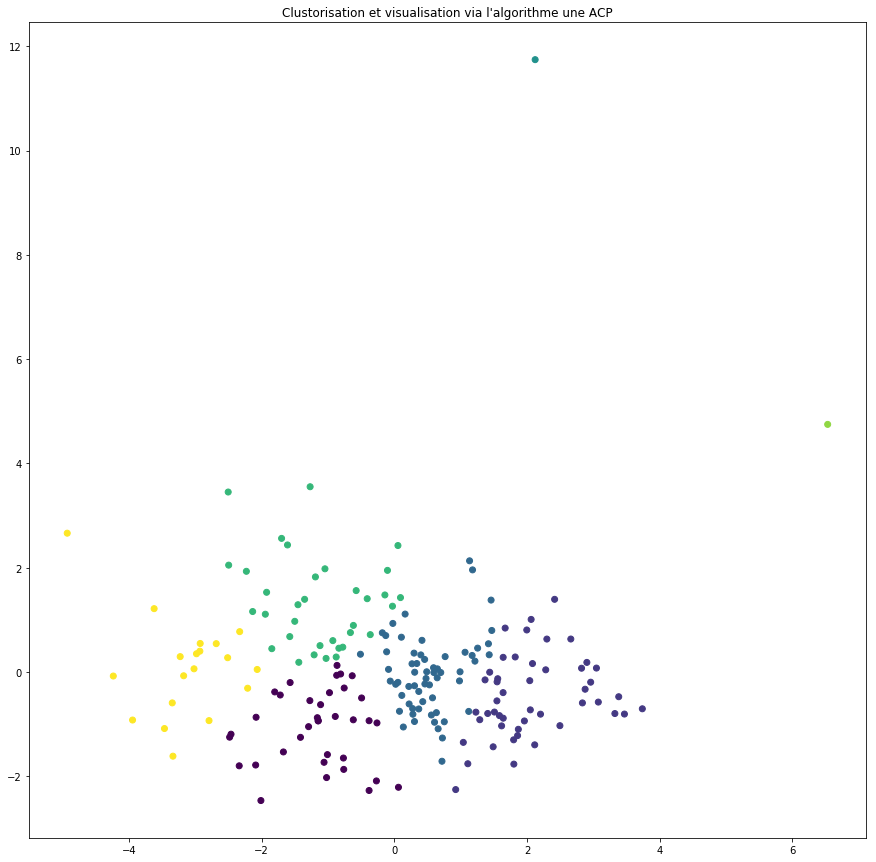

In [53]:
# visualiser une représentation en deux dimensions (clustering effectué sur la dimension réduite)

df_test = pd.read_csv('user_vecs_test0.csv')
visualisation_reduite(df=df_test,n_clusters=7)

(1000, 3)


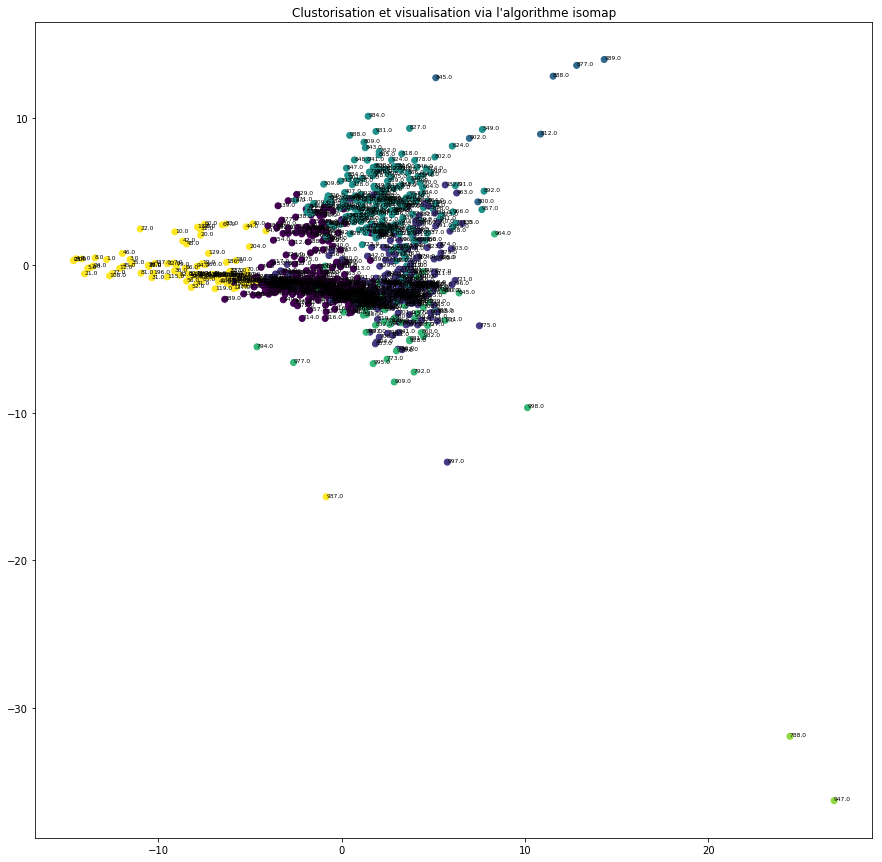

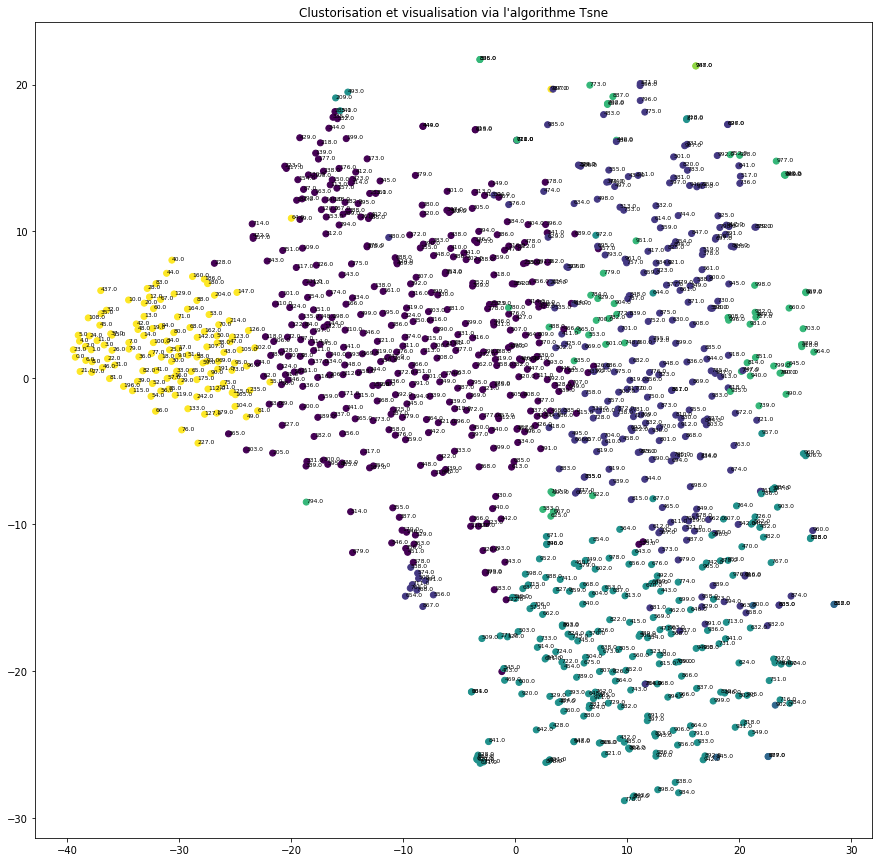

pourcentage de variance expliqué en deux dimensions
0.39856448664047495


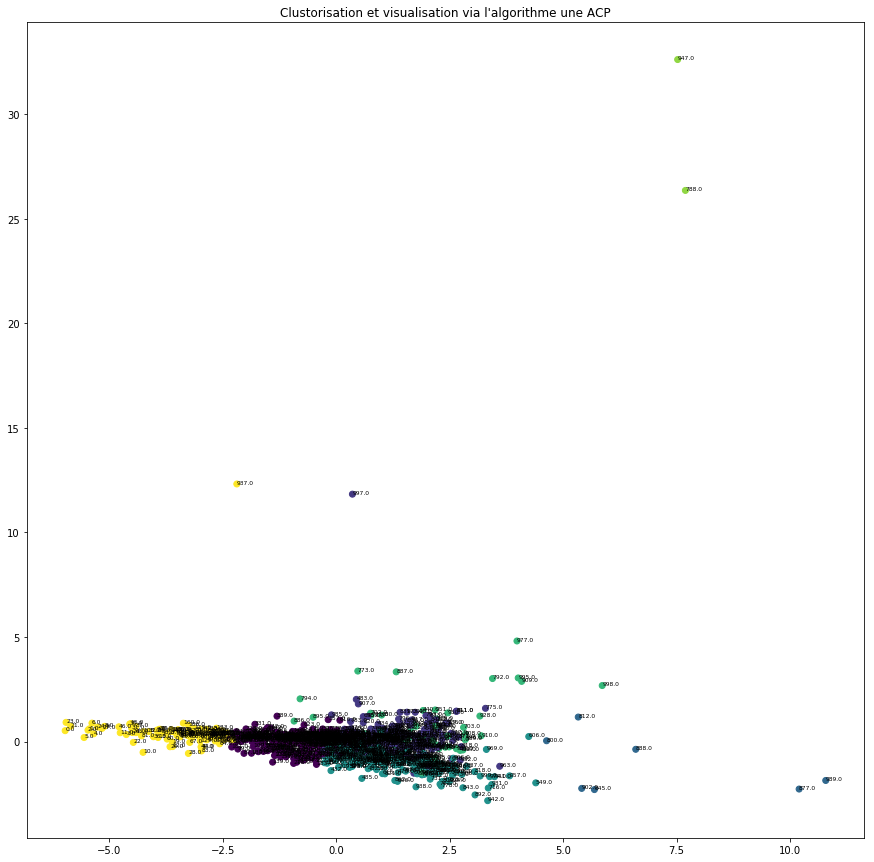

In [77]:
# visualiser une représentation en deux dimensions (clustering effectué sur la dimension réduite)

df_test = pd.read_csv('user_vecs_test0.csv')
visualisation_nonreduite(df=df_test,n_clusters=7)

# INTERPRETATION

Nous regardons pour certains utilisateurs de certains clusters (à la main) la liste des items consomés et comparons pour 
tenter de distinguer certaines caractéristiques.
La tache s'avére en réalité bien plus périlleuse que prévue. Cela vient du fait, que les clients ne sont vraisemblement pas des utilisateurs "lambda" mais sans doute des entreprises intermédiaires. En réalité ces entreprises vendent des produits de catégories similaires. L'ensemble des produits de notre base de donnée et des utilisateurs appartiennent en réalité à un seul type de catégorie, produits et accésoires pour décoration maison/jardin, de telle sorte qu'il soit, en pratique, sans connaissance des produits, très difficile de dinstinguer les clusters. 

Pourtant, nous pouvons noter deux choses : d'une part l'algorithme semble avoir identifier la caractéristique "nombre de transaction" comme pertinente. En effet les utilisateurs sont numerotés de manière inversement proportionelle au nombre de transaction effectuées et on distingue sur l'axe des abcises une croissance des étiquettes caractéristiques des utilisateurs.

De plus, principalement dans le cas où l'on observe la structue globale (algorithme ISOMAP) nous observons une forme de non linéarité et deux gros clusters. (haut et bas). Nous faisons l'hypothése que ces deux clusters sont liés à la popularité des produits achetés. 
Nous vérifions cette hypothèse.

In [80]:
# visualiser les éléments de certains clusters dans le but d'obtenir une description qualitative
title = pd.read_csv('fc_users_conv_red.csv')
item = pd.read_csv('fc_items_conv_red.csv')

df_basic = pd.read_csv('fc_data.csv')

In [181]:
# cluster 1 
cluster1 = [0,100,54,60,79,164,31,437]
titlec1 = title[(title.loc[:,'value']==0)|(title.loc[:,'value']==100)|(title.loc[:,'value']==54)]
               
print (titlec1)

     Unnamed: 0    number  value
0             1  N17841.0    0.0
54           55  N16686.0   54.0
100         101  N16746.0  100.0


In [184]:
A = df_basic[(df_basic.loc[:,'CustomerID']=='N17841.0')]
print (A.shape)
B = df_basic[(df_basic.loc[:,'CustomerID']=='N16686.0')]
print (B.shape)
A


(7183, 10)
(583, 10)


,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_bis
0,172778,551558,N84510A,SET OF 4 ENGLISH ROSE COASTERS,1,2011-05-03 10:41:00,1.25,N17841.0,United Kingdom,UK
62,257538,559535,N23281,FOLDING BUTTERFLY MIRROR RED,1,2011-07-10 12:16:00,0.83,N17841.0,United Kingdom,UK
64,218631,556056,N85059,FRENCH ENAMEL WATER BASIN,1,2011-06-08 13:35:00,3.75,N17841.0,United Kingdom,UK
283,502885,578852,N22597,MUSICAL ZINC HEART DECORATION,5,2011-11-27 11:12:00,0.29,N17841.0,United Kingdom,UK
349,108572,545545,N23182,TOILET SIGN OCCUPIED OR VACANT,2,2011-03-03 15:02:00,0.83,N17841.0,United Kingdom,UK
475,531504,580956,N21564,PINK HEART SHAPE LOVE BUCKET,3,2011-12-06 14:23:00,0.79,N17841.0,United Kingdom,UK
506,298179,562984,N22728,ALARM CLOCK BAKELIKE PINK,1,2011-08-11 11:45:00,3.75,N17841.0,United Kingdom,UK
544,479692,577174,N47422,ASSORTED MONKEY SUCTION CUP HOOK,8,2011-11-18 10:58:00,0.42,N17841.0,United Kingdom,UK
667,472026,576665,N21889,WOODEN BOX OF DOMINOES,1,2011-11-16 11:46:00,1.25,N17841.0,United Kingdom,UK
753,502890,578852,N22615,PACK OF 12 CIRCUS PARADE TISSUES,1,2011-11-27 11:12:00,0.39,N17841.0,United Kingdom,UK


In [183]:
mod_test =A[(A.loc[:,'StockCode']).isin(B.loc[:,'StockCode'])].reset_index(drop=True)
print (mod_test.shape)
print (mod_test)

(1545, 10)
      Unnamed: 0  InvoiceNo StockCode                          Description  \
0         172778     551558   N84510A       SET OF 4 ENGLISH ROSE COASTERS   
1         472026     576665    N21889               WOODEN BOX OF DOMINOES   
2         221405     556245    N22964   3 PIECE SPACEBOY COOKIE CUTTER SET   
3         244899     558558    N79321                        CHILLI LIGHTS   
4         502902     578852    N22621           TRADITIONAL KNITTING NANCY   
5         502850     578852    N23192  BUNDLE OF 3 ALPHABET EXERCISE BOOKS   
6         365690     568712    N22621           TRADITIONAL KNITTING NANCY   
7         495099     578289    N22487       WHITE WOOD GARDEN PLANT LADDER   
8         407086     571846    N22753      SMALL YELLOW BABUSHKA NOTEBOOK    
9         295226     562779    N22766                  PHOTO FRAME CORNICE   
10        295227     562779   N84078A     SET/4 WHITE RETRO STORAGE CUBES    
11        519171     580136    N22328   ROUND SNACK B

In [23]:
df_basic[(df_basic.loc[:,'CustomerID']=='N15123.0')]

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_bis
338,520337,580279,N21788,KIDS RAIN MAC BLUE,24,2011-12-02 13:12:00,0.85,N15123.0,United Kingdom,UK
1455,193401,553527,N22557,PLASTERS IN TIN VINTAGE PAISLEY,12,2011-05-17 14:57:00,1.65,N15123.0,United Kingdom,UK
5548,193399,553527,N22326,ROUND SNACK BOXES SET OF4 WOODLAND,6,2011-05-17 14:57:00,2.95,N15123.0,United Kingdom,UK
17493,193406,553527,N22548,HEADS AND TAILS SPORTING FUN,12,2011-05-17 14:57:00,1.25,N15123.0,United Kingdom,UK
19815,193407,553527,N22560,TRADITIONAL MODELLING CLAY,24,2011-05-17 14:57:00,1.25,N15123.0,United Kingdom,UK
21995,520342,580279,N22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-12-02 13:12:00,8.50,N15123.0,United Kingdom,UK
25158,520338,580279,N21789,KIDS RAIN MAC PINK,24,2011-12-02 13:12:00,0.85,N15123.0,United Kingdom,UK
32789,193398,553527,N84997A,CHILDRENS CUTLERY POLKADOT GREEN,4,2011-05-17 14:57:00,4.15,N15123.0,United Kingdom,UK
33190,193417,553527,N21535,RED RETROSPOT SMALL MILK JUG,6,2011-05-17 14:57:00,2.55,N15123.0,United Kingdom,UK
40683,520376,580279,N22915,ASSORTED BOTTLE TOP MAGNETS,36,2011-12-02 13:12:00,0.42,N15123.0,United Kingdom,UK


In [96]:
df_basic[(df_basic.loc[:,'CustomerID']=='N16686.0')]

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_bis
1432,412677,572295,N22641,SET OF 4 NAPKIN CHARMS INSTRUMENT,3,2011-10-23 13:49:00,2.55,N16686.0,United Kingdom,UK
2145,83472,543306,N22483,RED GINGHAM TEDDY BEAR,1,2011-02-07 11:56:00,2.95,N16686.0,United Kingdom,UK
3504,37697,539475,N21372,MIRRORED WALL ART TABLE LAMP,1,2010-12-19 14:41:00,2.95,N16686.0,United Kingdom,UK
4842,412780,572295,N23388,WOODLAND MINI BACKPACK,1,2011-10-23 13:49:00,4.15,N16686.0,United Kingdom,UK
5917,207521,554992,N22326,ROUND SNACK BOXES SET OF4 WOODLAND,1,2011-05-29 14:08:00,2.95,N16686.0,United Kingdom,UK
6419,83457,543306,N84997A,GREEN 3 PIECE POLKADOT CUTLERY SET,2,2011-02-07 11:56:00,4.15,N16686.0,United Kingdom,UK
6965,315460,564727,N22717,CARD DOG AND BALL,12,2011-08-28 12:31:00,0.42,N16686.0,United Kingdom,UK
7071,207492,554992,N22742,MAKE YOUR OWN PLAYTIME CARD KIT,1,2011-05-29 14:08:00,2.95,N16686.0,United Kingdom,UK
7288,83459,543306,N22367,CHILDRENS APRON SPACEBOY DESIGN,3,2011-02-07 11:56:00,1.95,N16686.0,United Kingdom,UK
9003,37699,539475,N21747,SMALL SKULL WINDMILL,1,2010-12-19 14:41:00,1.25,N16686.0,United Kingdom,UK


In [98]:
# cluster 2 
cluster2 = [556,867,768,711,654,508]
titlec2 = title[(title.loc[:,'value']==556)|(title.loc[:,'value']==867)|(title.loc[:,'value']==768)|
               (title.loc[:,'value']==711)|(title.loc[:,'value']==654)|(title.loc[:,'value']==508)]
print (titlec2)

     Unnamed: 0    number  value
508         509  N16626.0  508.0
556         557  N17837.0  556.0
654         655  N17863.0  654.0
711         712  N14387.0  711.0
768         769  N14382.0  768.0
867         868  N13115.0  867.0


In [99]:
df_basic[(df_basic.loc[:,'CustomerID']=='N16626.0')]


,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_bis
3189,541709,581567,N22625,RED KITCHEN SCALES,2,2011-12-09 11:56:00,8.50,N16626.0,United Kingdom,UK
3450,218033,555949,N84944,SET OF 6 KASHMIR FOLKART BAUBLES,12,2011-06-08 10:50:00,1.65,N16626.0,United Kingdom,UK
4045,218014,555949,N21479,WHITE SKULL HOT WATER BOTTLE,4,2011-06-08 10:50:00,3.75,N16626.0,United Kingdom,UK
9673,478476,577084,N22625,RED KITCHEN SCALES,2,2011-11-17 15:41:00,8.50,N16626.0,United Kingdom,UK
10067,290100,562351,N21326,AGED GLASS SILVER T-LIGHT HOLDER,48,2011-08-04 13:10:00,0.65,N16626.0,United Kingdom,UK
17292,124617,546983,N21417,COCKLE SHELL DISH,6,2011-03-18 12:27:00,2.10,N16626.0,United Kingdom,UK
21990,236654,557769,N21326,AGED GLASS SILVER T-LIGHT HOLDER,12,2011-06-22 14:38:00,0.65,N16626.0,United Kingdom,UK
28936,124573,546983,N22178,VICTORIAN GLASS HANGING T-LIGHT,12,2011-03-18 12:27:00,1.25,N16626.0,United Kingdom,UK
30072,218016,555949,N21326,AGED GLASS SILVER T-LIGHT HOLDER,12,2011-06-08 10:50:00,0.65,N16626.0,United Kingdom,UK
31544,218021,555949,N21213,PACK OF 72 SKULL CAKE CASES,24,2011-06-08 10:50:00,0.55,N16626.0,United Kingdom,UK


In [100]:
df_basic[(df_basic.loc[:,'CustomerID']=='N17837.0')]

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_bis
5089,379442,569693,N23348,CHILDRENS TOY COOKING UTENSIL SET,3,2011-10-05 15:18:00,2.08,N17837.0,United Kingdom,UK
10458,398857,571258,N22510,GINGHAM BABUSHKA DOORSTOP,1,2011-10-14 17:23:00,3.75,N17837.0,United Kingdom,UK
14716,425137,573305,N22115,METAL SIGN EMPIRE TEA,4,2011-10-28 16:13:00,0.79,N17837.0,United Kingdom,UK
16389,359357,568186,N23439,HAND WARMER RED LOVE HEART,2,2011-09-25 14:08:00,2.10,N17837.0,United Kingdom,UK
20463,425123,573305,N85014A,BLACK/BLUE POLKADOT UMBRELLA,1,2011-10-28 16:13:00,5.95,N17837.0,United Kingdom,UK
30477,425154,573305,N23555,LANDMARK FRAME NOTTING HILL,2,2011-10-28 16:13:00,12.50,N17837.0,United Kingdom,UK
33471,359365,568186,N22508,DOORSTOP RETROSPOT HEART,1,2011-09-25 14:08:00,3.75,N17837.0,United Kingdom,UK
44249,264527,560103,N22634,CHILDS BREAKFAST SET SPACEBOY,2,2011-07-14 18:44:00,9.95,N17837.0,United Kingdom,UK
48061,359361,568186,N21623,VINTAGE UNION JACK MEMOBOARD,2,2011-09-25 14:08:00,9.95,N17837.0,United Kingdom,UK
48199,379424,569693,N90200E,GREEN SWEETHEART BRACELET,1,2011-10-05 15:18:00,4.25,N17837.0,United Kingdom,UK


In [101]:
df_basic[(df_basic.loc[:,'CustomerID']=='N17863.0')]

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_bis
1821,391110,570652,N84832,ZINC WILLIE WINKIE CANDLE STICK,24,2011-10-11 13:45:00,0.85,N17863.0,United Kingdom,UK
2998,391097,570652,N22737,RIBBON REEL CHRISTMAS PRESENT,10,2011-10-11 13:45:00,1.65,N17863.0,United Kingdom,UK
3781,139082,548276,N22631,CIRCUS PARADE LUNCH BOX,12,2011-03-30 11:39:00,1.95,N17863.0,United Kingdom,UK
4129,266702,560265,N21508,VINTAGE KID DOLLY CARD,24,2011-07-17 13:48:00,0.42,N17863.0,United Kingdom,UK
7392,79285,542928,N21094,SET/6 RED SPOTTY PAPER PLATES,12,2011-02-02 10:22:00,0.85,N17863.0,United Kingdom,UK
15425,391101,570652,N23319,BOX OF 6 MINI 50'S CRACKERS,18,2011-10-11 13:45:00,2.49,N17863.0,United Kingdom,UK
18501,139081,548276,N22662,LUNCH BAG DOLLY GIRL DESIGN,10,2011-03-30 11:39:00,1.65,N17863.0,United Kingdom,UK
19023,348300,567386,N21915,RED HARMONICA IN BOX,12,2011-09-20 10:38:00,1.25,N17863.0,United Kingdom,UK
21394,79276,542928,N22539,MINI JIGSAW DOLLY GIRL,24,2011-02-02 10:22:00,0.42,N17863.0,United Kingdom,UK
21869,9028,537163,N22712,CARD DOLLY GIRL,12,2010-12-05 13:21:00,0.42,N17863.0,United Kingdom,UK


In [102]:
# cluster 3 
cluster3 = [914,745,642,432,749]
titlec3 = title[(title.loc[:,'value']==914)|(title.loc[:,'value']==745)|(title.loc[:,'value']==652)|
               (title.loc[:,'value']==432)|(title.loc[:,'value']==749)]
print (titlec3)

     Unnamed: 0    number  value
432         433  N16891.0  432.0
652         653  N13901.0  652.0
745         746  N16889.0  745.0
749         750  N13340.0  749.0
914         915  N17504.0  914.0


Nous vérifions l'hypothèse selon laquelle les deux gros clusters nord sud discrétisent la popularité des items consomés. 
Pour cela, nous créons une droite séparatrice et nous enregistrons les étiquettes des utilisateurs dans deux listes de part et d'autre de cette droite. 
Parallélement nous créons un indicateur dont chaque item posséde une valeur propre. Cet indicateur est basé sur le nombre d'utilisateurs différents ayant acheté le produit. 
Pour chaque utilisateur nous itérons sur la liste des produits achetés et nous moyenons l'indicateur de l'ensemble de ces produits. 

Nous faisons enfin la moyenne de l'indicateur sur chaqu'une des deux listes et comparons les résultats. 

In [24]:
def visu_test(df,n_clusters):
    # ouvrir les annotations 
    
    title = pd.read_csv('fc_users_conv_red.csv')
    print (title.shape)
    df = StandardScaler().fit_transform(df)
    
    # appliquer le k-means en incluant toutes les dimensions
    kmeans = KMeans(n_clusters=int(n_clusters),init='k-means++' ,random_state=0).fit(df)
    
    
    
    # ---------------------------- appliquer isomap (structure plutôt globale)----------------------------------

    iso = manifold.Isomap(n_neighbors=4,      
                           n_components=2)
    X_iso = iso.fit_transform(df)
    
    list_up = []
    list_down = []
    for i in range (X_iso.shape[0]):
        
        if (X_iso[i,1] > -(1./10) * X_iso[i,0] + 1):
            list_up.append(title.iloc[i,2])
        if (X_iso[i,1] < -(1./10) * X_iso[i,0] + 1):
            list_down.append(title.iloc[i,2])
            
    # représenter les données 

    fig, ax = plt.subplots(figsize=(15, 15))  

    for i in range(title.shape[0]):    

        ax.annotate(title.iloc[i,2], (X_iso[i,0], X_iso[i,1]),size=6)
    plt.scatter(X_iso[:, 0], X_iso[:, 1],c=kmeans.labels_)
    plt.plot([0,10], [1,0],'-', markersize=6, c='red')
    plt.title("Clustorisation et visualisation via l'algorithme isomap")
    #plt.axis([-2, 2, -2, 2])
    plt.savefig('user_map_iso.png', dpi=400)
    plt.show()
            
    return (list_up, list_down)
        
    

(1000, 3)


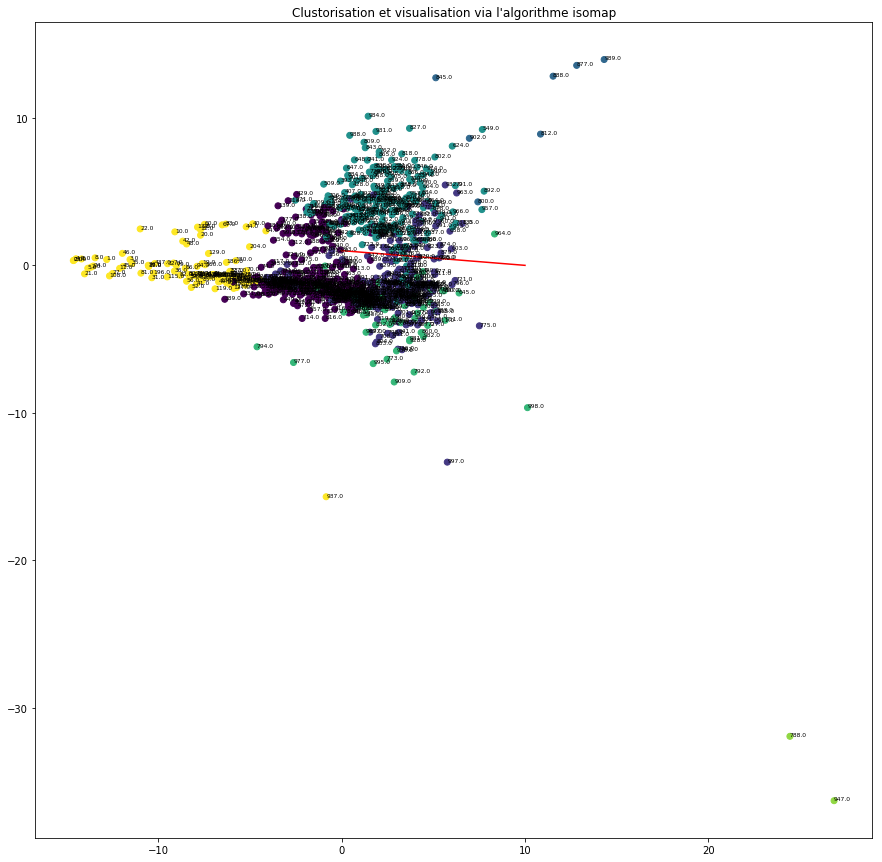

In [25]:
# visualiser une représentation en deux dimensions (clustering effectué sur l'ensemble des dimensions)
# la droite séparatrice est visible en rouge 

df_test = pd.read_csv('user_vecs_test0.csv')
list_up, list_down = visu_test(df=df_test,n_clusters=7)

In [ ]:
def plot_value_counts(col_name,df):       
    
    values_count = pd.DataFrame(df[col_name].dropna().value_counts())    
    values_count.columns = ['count']
    
    # convert the index column into a regular column.
    values_count[col_name] = [ str(i) for i in values_count.index ]
    
    # add a column with the percentage of each data point to the sum of all data points.
    values_count['percent'] = values_count['count'].div(values_count['count'].sum()).multiply(100).round(2)
    
    # change the order of the columns.
    values_count = values_count.reindex([col_name,'count','percent'],axis=1)
    values_count.reset_index(drop=True,inplace=True)
    
    return (values_count)


#-------------------------
# LOAD AND PREP THE DATA
#-------------------------
 
data_cf = pd.read_csv('fc_matrix_red.csv')

# ------------------------------ COMPUTING NAIF CLASSIFIORS  ----------------------------------
        
        
# number of users 
users_testset = plot_value_counts(col_name='userID',df=data_cf)
users_testset.iloc[:,0] = pd.to_numeric(users_testset.iloc[:,0], errors='coerce').fillna(0, downcast='infer')

# number of items 
items_testset = plot_value_counts(col_name='itemID',df=data_cf)
items_testset.iloc[:,0] = pd.to_numeric(items_testset.iloc[:,0], errors='coerce').fillna(0, downcast='infer')
                
              
# classifior based on the transaction number for each item
items_naif1 = np.zeros(items_testset.shape[0])
        
# classifior based on the number of user who did a transaction for each item
items_naif2 = np.zeros(items_testset.shape[0])
        
for i in range (items_testset.shape[0]):
            
    df_trans = data_cf[data_cf.loc[:,'itemID'] == items_testset.iloc[i,0]]
    items_naif1[i] = np.sum(df_trans.loc[:,'rating'])          
            
            
    for j in range (users_testset.shape[0]):                
                
        df_trans2 = df_trans[df_trans.loc[:,'userID'] == users_testset.iloc[j,0]]      
                    
        if (df_trans2.iloc[0,4] > 0):                 
                    
            items_naif2[i] = items_naif2[i] + 1            
                    
        
                        
# arranger dans le dataframe pandas 'valeurs_items'
items_testset['naif1'] = items_naif1[:]
items_testset['naif2'] = items_naif2[:]

In [ ]:
# calcul de l'indicateur de popularité dans chaqu'un des deux clusters

value_up = np.zeros(len(list_up))
print (len(list_up))

for i in range (len(list_up)):
    
    data_cf2 = data_cf[data_cf.loc[:,'userID']==list_up[i]]
    data_cf2 = data_cf2[data_cf2.loc[:,'rating']>0]
    ind_item = data_cf2.columns.get_loc('itemID')
    
    for j in range (data_cf2.shape[0]):
        
        a = items_testset[items_testset.iloc[:,0]==data_cf2.iloc[j,ind_item]]
        value_up[i] = value_up[i] + np.sum(a.loc[:,'naif2'])/data_cf2.shape[0]
                                     
value_down = np.zeros(len(list_down))
print (len(list_down))

for i in range (len(list_up)):
    
    data_cf2 = data_cf[data_cf.loc[:,'userID']==list_up[i]]
    data_cf2 = data_cf2[data_cf2.loc[:,'rating']>0]
    ind_item = data_cf2.columns.get_loc('itemID')
    
    for j in range (data_cf2.shape[0]):
        
        a = items_testset[items_testset.iloc[:,0]==data_cf2.iloc[j,ind_item]]
        value_down[i] = value_down[i] + np.sum(a.loc[:,'naif2'])/data_cf2.shape[0]

In [186]:
print ('moyenne de popularité du cluster haut')
print (np.mean(value_up[:]))
print ('moyenne de popularité du cluster bas')
print (np.mean(value_down[:]))

# inclure ces informations dans un dataset 
d = {'cluster':['haut','bas'],'popularité des items':[np.mean(value_up[:]),np.mean(value_down[:])],
     'importance en %':[len(value_up)/(len(value_up)+len(value_down)),len(value_down)/(len(value_up)+len(value_down))]
    }
info = pd.DataFrame(data=d)
info

moyenne de popularité du cluster haut
142.2508991292861
moyenne de popularité du cluster bas
65.41464704485419


,cluster,popularité des items,importance en %
0,haut,142.250899,0.315
1,bas,65.414647,0.685


# II) Prédiction d'un cluster pour un nouvel utilisateur

On peut prédire pour une série de transactions (superieure ou égale à 1) les vecteurs utilisateurs d'un nouvel utilisateur.
Pour cela, nous importons les vecteurs "items" du modèle collaboratif. L'équation est la suivante.

Etant donné les difficultés d'interprétations du modèle collaboratif, nous préférons nous concentrer sur sur le modèle manuel plus prometteur. Nous choisissons tout de même, suite à cet analyse d'incorporer manuellement une nouvelle variable indicatrice de la popolarité des items consommés par un utilisateur.